#  main program for ICM-DOM-PD for python
#  a highly modularized code based on Cerco and Coel 1993 estuarine model
#  of Chesapeake Bay

#  Modified from Clark et al. 2020 to include more complex
#  light reactions and photochemistry

In [9]:
import os
import sys
# Find where we are on the computer and make sure it is the pyICM directory
HomeDir = os.path.expanduser('~')  # get the home directory

ICMDir = HomeDir + "/Desktop/pyICM"
# Navigate to the home directory
os.chdir(ICMDir)
print('Moved to Directory',ICMDir)

Moved to Directory /Users/jbclark8/Desktop/pyICM


In [10]:
module_path = os.path.join(ICMDir,'code')
print('Code Directory is',module_path)
print('Adding to the system path')
if module_path not in sys.path:
    sys.path.append(module_path)

Code Directory is /Users/jbclark8/Desktop/pyICM/code
Adding to the system path


In [12]:
# Common python libraries needed for this code
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# IMPORT ALL OF THE LIBRARIES AND FILES USED FOR ICM
import Density
import functions
import DefVars as dv
import Light
import Sediment as sed
import Nutrients as nt
import DOM
import POM
import Algae
import Oxygen
import glob
print('Successfully imported all Modules')

Successfully imported all Modules


In [14]:
print("Hello! Welcome to ICM." "\n"
      "This current version is for Chesapeake Bay" "\n"
      "Station data is read variables are dynamically calculated. This is version 0.1")

WhichData = 'Chesapeake'
StatDir = ICMDir+"/Inputs/"+WhichData

Hello! Welcome to ICM.
This current version is for Chesapeake Bay
Station data is read variables are dynamically calculated. This is version 0.1


In [17]:
WhichData = 'Chesapeake'
StatDir = ICMDir+"/Inputs/"+WhichData

StatFiles = sorted(glob.glob(StatDir+"/CBP/*.csv"))

print("These are the following files available")

# Show all available files
ii = 0
for ff in StatFiles:
    f1 = ff.split('/')
    f1 = f1[len(f1)-1]
    f1 = f1.split("_")

    print(ii+1, ". ", f1[0])

    ii = ii+1

fnum = int(input("Which station file from the list would you like to run?"
                 "\n'"
                 "Enter number here ---> "))

WQ_fname = StatFiles[fnum-1]
print("File Selected is --> ", WQ_fname)

These are the following files available
1 .  CB1.1
2 .  CB2.1
3 .  CB2.2
4 .  CB3.1
5 .  CB3.2
6 .  CB3.3C
7 .  CB4.1C
8 .  CB4.2C
9 .  CB4.3C
10 .  CB4.4
11 .  CB5.1
12 .  CB5.2
13 .  CB5.3
14 .  CB5.4
15 .  CB5.5
16 .  CB6.1
17 .  CB6.2
18 .  CB6.3
19 .  CB6.4
20 .  CB7.1
21 .  CB7.2
22 .  CB7.3
23 .  CB7.4
24 .  CB8.1
Which station file from the list would you like to run?
'Enter number here ---> 8
File Selected is -->  /Users/jbclark8/Desktop/pyICM/Inputs/Chesapeake/CBP/CB4.2C_Climatology.csv


In [18]:
# get the station name from the file name, to match the weather data
Fin = WQ_fname.split('/')
Fin = Fin[len(Fin)-1]
Fin = Fin.split('_')
StatName = Fin[0]

LAT = 38
LON = -76
yy = 2020

In [19]:
# read in the time series data  of water quality inputs
myTS = pd.read_csv(WQ_fname)

# read in spectral information for light attenuation
Light_fname = StatDir + "/CBay_Spectral.csv"
myLT = pd.read_csv(Light_fname)

# read in surface forcing information for light and weather
weather_fname = StatDir+"/Weather/"+StatName+"_Weather.csv"
mySFC = pd.read_csv(weather_fname)

In [20]:
errorcode = dv.InitializeVariables()
if(errorcode == 1):
    print('All variables were not defined, there is a problem and ICM is\
          stopping')
elif(errorcode == 0):
    print('All global variables have been defined')

All global variables have been defined


# First we have to define the space and time dimensions
# We can change the spatial dimensions if need be, by default
# the are 10 km x 10 km x 10 m
# dv is the DefVars module which contains the values for all of the global
# parameters. In there the user can find many parameters of interest.

In [23]:
print('X= ',dv.X, ' m, Y= ', dv.Y,' m, Z= ',dv.Z,' m ')
# calculate the domain volume, specified in DefVars
Volume = functions.CalcVolume(dv.X, dv.Y, dv.Z)
print('Volume =', Volume*1e-9, 'km^3')

# now set up the time vector for integration, using the forcing file time
modtimein = myTS.Time
lasttime = modtimein[len(modtimein)-1]
print('Start and End Days are = ', modtimein[0]/86400, lasttime/86400)

X=  10000.0  m, Y=  10000.0  m, Z=  10.0  m 
Volume = 1.0 km^3
Start and End Days are =  1.0 365.0


In [24]:
# set the time step here
DT = 3600.
Nsteps = int(lasttime/DT)
# now set up a time array with the appropriate time step
modtime = np.linspace(modtimein[0], lasttime, Nsteps)
current_time = modtime[0]

print('My Time Step is = ', DT, 'Seconds')
#total number of time steps
mylen = len(modtime)

My Time Step is =  3600.0 Seconds


# Now we will read in the station data as "River" forcing
# the weather data as the surface forcing
# and the spectral parameterization for the light calculations

# Some suggested experiments are 
# Change the river input flow (static currently)
# Change the river input concentrations
# The river input temperature
# The wind velocity
# Or the surface temperature

In [35]:
# RIVER FLOW
Q = np.ones(mylen)*500.
# RIVER INPUTS
# Water Temperature
Tin = myTS.WTEMP
# Water Salinity
Sin = myTS.SALINITY
# Nitrogen
RivNH4in = myTS.NH4F
RivNO3in = myTS.NO23F
# Convert upstream chl a concentration into algae 1 and 2 carbon
RivAlgae1in = myTS.CHLA*0.5*dv.cchla1*1e-3
RivAlgae2in = myTS.CHLA*0.5*dv.cchla1*1e-3
# calculate the change in concentration due to river inputs
RiverISSin = myTS.TSS

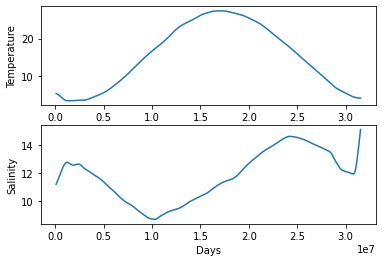

In [42]:
# now we can plot some of these forcings
# 
Fig1,(ax1,ax2)=plt.subplots(2)
ax1.plot(modtimein,Tin)
ax1.set(xlabel='Days')
ax1.set(ylabel='Temperature')
ax2.plot(modtimein,Sin)
ax2.set(xlabel='Days')
ax2.set(ylabel='Salinity')
plt.show()

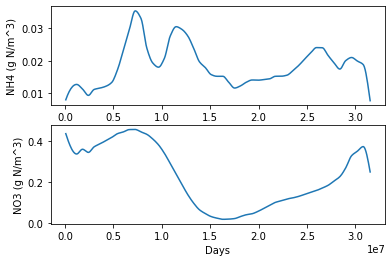

In [43]:
Fig1,(ax1,ax2)=plt.subplots(2)
ax1.plot(modtimein,RivNH4in)
ax1.set(xlabel='Days')
ax1.set(ylabel='NH4 (g N/m^3)')
ax2.plot(modtimein,RivNO3in)
ax2.set(xlabel='Days')
ax2.set(ylabel='NO3 (g N/m^3)')
plt.show()

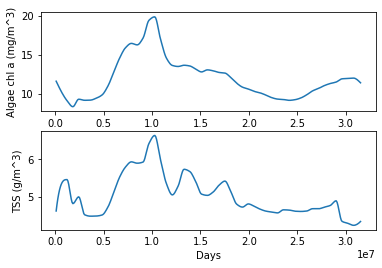

In [44]:
Fig1,(ax1,ax2)=plt.subplots(2)
ax1.plot(modtimein,myTS.CHLA)
ax1.set(xlabel='Days')
ax1.set(ylabel='Algae chl a (mg/m^3)')
ax2.plot(modtimein,myTS.TSS)
ax2.set(xlabel='Days')
ax2.set(ylabel='TSS (g/m^3)')
plt.show()

In [45]:
# SURFACE FORCING
# wind velocity
Uin = mySFC.uwnd[0:365]
Vin = mySFC.vwnd[0:365]
# total downwelling shortwave flux and scale by 0.43 to remove IR
EdIn = mySFC.dswrf*0.43

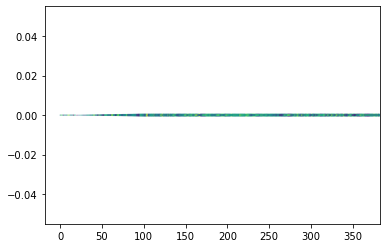

In [46]:
plt.quiver(modtimein,Uin,Vin)
plt.show()

In [50]:
# LIGHT PARAMETERS
# wavelengths, nm
WL = myLT.Lambda
# absorption due to water, m^-1
aWater = myLT.aW
# mass specific absorption for each colored DOC, m^2 gC^-1
aC1 = myLT.aCDOC1
aC2 = myLT.aCDOC2
aC3 = myLT.aCDOC3
# take the averge for now
aCDOC = np.average(np.column_stack((aC1, aC2, aC3)), 1)
# mass specific absorption due to chla, m^2 mg chla^-1
aPhi = myLT.aPhi
# mass specific absorption due to particles, m^2 g^-1
aP = myLT.aP
# mass specific backscattering due to particles, m^2 g^-1
bbP = myLT.bbp
# spectral distribution of light, nm^-1
SpecDis = myLT.Spec_dist

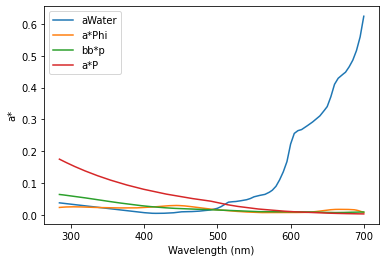

In [54]:
plt.plot(WL,aWater,label="aWater")
plt.plot(WL,aPhi,label="a*Phi")
plt.plot(WL,bbP,label="bb*p")
plt.plot(WL,aP,label="a*P")
plt.xlabel('Wavelength (nm)')
plt.ylabel('a*')
plt.legend()
plt.show()

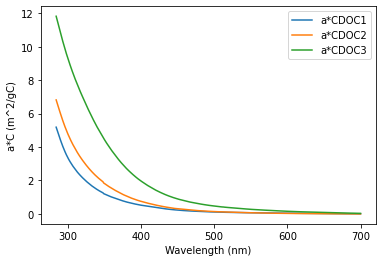

In [55]:
plt.plot(WL,aC1,label="a*CDOC1")
plt.plot(WL,aC2,label="a*CDOC2")
plt.plot(WL,aC3,label="a*CDOC3")
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('a*C (m^2/gC)')
plt.show()

Text(0, 0.5, 'Spectral Distribution')

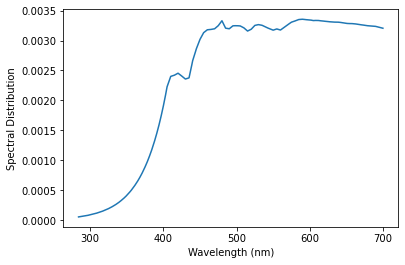

In [56]:
plt.plot(WL,SpecDis)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Spectral Distribution')

In [57]:
# interpolate all forcing to the model time step
T = np.interp(modtime, modtimein, Tin)
S = np.interp(modtime, modtimein, Sin)
Speed = np.sqrt(Uin ** 2 + Vin ** 2)
Uwind = np.interp(modtime, modtimein, Speed)

RivNH4 = np.interp(modtime, modtimein, RivNH4in)
RivNO3 = np.interp(modtime, modtimein, RivNO3in)
RivAlgae1 = np.interp(modtime, modtimein, RivAlgae1in)
RivAlgae1 = np.interp(modtime, modtimein, RivAlgae2in)
RiverISS = np.interp(modtime, modtimein, RiverISSin)

In [59]:
# %%%%%%%%%%%%%%%% INITIALIZE ALL WATER QUALITY VARIABLES %%%%%%%%%%%%%%%%%%
# After running the model a few times, can take the last value and input here
# phytoplankton 1 and 2 biomass (g C m^-3)
B1 = np.zeros(mylen)
B1[0] = 0.1
B2 = np.zeros(mylen)
B2[0] = 0.1

# phytoplankton 1 and 2 chla
# convert carbon to chla in micrograms L6-1
chla1 = B1 / dv.cchla1 * 1e3
chla2 = B2 / dv.cchla2 * 1e3
chla = chla1 + chla2

# #ammonium and nitrate concentration (g N m^-3)
NH4 = np.zeros(mylen)
NH4[0] = 0.05

NO3 = np.zeros(mylen)
NO3[0] = 0.1


# dissolved oxygeen
DO2 = np.zeros(mylen)
DO2[0] = 10.0

# temp var for DON remineralization
MNLDON = 0.05

# set up an array for KD, PAR, and NP_Total to collect and pass back to main
# from the light attenuation function
KD = np.zeros((mylen, len(WL)))
PAR = np.zeros(mylen)
KD_PAR = np.zeros(mylen)
NP_total = np.zeros((mylen, len(WL)))
EdAvg = np.zeros((mylen, len(WL)))
# now find where WL == 400 and WL == 700 to mark off the PAR
dv.PAR_Id[0] = (np.abs(WL - 400.)).argmin()
dv.PAR_Id[1] = (np.abs(WL - 700.)).argmin()

# #colored and non-colored DOC concentration (g C m^-3)
CDOC = np.ones(mylen)
# NCDOC=np.zeros(mylen)
MNLDOC = 0.0
# #colored and non-colored DON concentration (g N m^-3)
# CDON=np.zeros(mylen)
# NCDON=np.zeros(mylen)

# #Labile and Refractory POC and PON in g C and g N m^-3
LPOC = np.zeros(mylen)
LPOC[0] = 0.5
RPOC = np.zeros(mylen)
RPOC[0] = 1.0
# LPON=np.zeros(mylen)
# RPON=np.zeros(mylen)

# inorganic suspended sediment (g m^-3)
ISS = np.zeros(mylen)
ISS[0] = 10.

# TSS = np.zeros(mylen)
TSS = ISS + (LPOC + RPOC) * 2.5

# Phytoplankton Rate Variables
SZA = np.zeros(mylen-1)
FI1 = np.zeros(mylen)
FI2 = np.zeros(mylen)
NL1 = np.zeros(mylen)
NL2 = np.zeros(mylen)
NPP1 = np.zeros(mylen)
NPP2 = np.zeros(mylen)
P1 = np.zeros(mylen)
P2 = np.zeros(mylen)
PR1 = np.zeros(mylen)
PR2 = np.zeros(mylen)
PN1 = np.zeros(mylen)
PN2 = np.zeros(mylen)

NT = np.zeros(mylen)

# Now all variables are initialized and all forcing is specified
# The main loop is ready to begin
# The main loop calculates the change in concentration and the new concentration
# over time at time interval DT
# The model is integrated using simple Euler (forward) integration and 
# can therefore be unstable at longer time steps
# A short time step is highly recommended
# the model runs until it reaches the end of the river time series 
# and calls the functions within each module for each dynamic
# water quality constituent

In [61]:

i = 1
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% BEGIN MAIN LOOP %%%%%%%%%%%%%%%%%%%%%%%%%%%%
while current_time < modtime[len(modtime)-1]:

    JDAY = current_time/86400
    MyDay = np.floor(JDAY)

    # calculate the total absorption and the total scattering
    aTotal = (aWater + chla[i-1] * aPhi +
              CDOC[i-1] * aCDOC +
              TSS[i-1] * aP)
    bTotal = TSS[i-1] * bbP

    # call the light attenuation functions
    KD[(i-1, )], PAR[i-1], NP_total[(i-1, )], KD_PAR[i-1], EdAvg[i-1, ] = \
        Light.Light_Attenuation(WL, EdIn[MyDay],
                                aTotal, bTotal, dv.Z*0.1,
                                JDAY, LAT, LON, yy)

    FRate = functions.CalcFlushingRate(Q[i-1], Volume)

# calculate the change in concentration due to biogeochemical processes
# first algal growth and death
    Algae1 = Algae.DTB1(B1[i-1], NH4[i-1], NO3[i-1], T[i-1],
                        PAR[i-1], FRate, RivAlgae1[i-1], Q[i-1], Volume)
    Algae2 = Algae.DTB2(B2[i-1], NH4[i-1], NO3[i-1], T[i-1],
                        PAR[i-1], FRate, RivAlgae1[i-1], Q[i-1], Volume)
# get some of the algae rates
    FI1[i] = Algae1.FI
    FI2[i] = Algae2.FI
    NL1[i] = Algae1.NL
    NL2[i] = Algae2.NL
    NPP1[i] = Algae1.NPP
    NPP2[i] = Algae2.NPP
    P1[i] = Algae1.P1
    P2[i] = Algae2.P2
    PR1[i] = Algae1.PR1
    PR2[i] = Algae2.PR2
    PN1[i] = Algae1.PN
    PN2[i] = Algae2.PN

# next inorganic nitrogen
    NH4A = Algae1.NH4A+Algae2.NH4A
    NO3A = Algae1.NO3A+Algae2.NO3A

    DTNO3 = nt.DTNO3(NH4[i-1], NO3[i-1], T[i-1], DO2[i-1], NO3A,
                     Q[i-1], Volume, FRate, RivNO3[i-1])
    DTNH4 = nt.DTNH4(NH4[i-1], NO3[i-1], T[i-1], DO2[i-1], MNLDON,
                     NH4A, Q[i-1], Volume, FRate, RivNH4[i-1])
# nitrification
    NT[i] = nt.Nitrification(NH4[i-1], T[i-1], DO2[i-1])

# inorganic sediment
    DTISS = sed.deltaISS(Q[i-1], Volume, FRate, RiverISS[i-1], ISS[i-1])

# next calculate dissolved oxygen
    DTDO2 = Oxygen.DOXG(DO2[i-1], T[i], S[i], dv.Z,
                        PN1[i], PN2[i], P1[i], P2[i], PR1[i],
                        PR2[i], B1[i], B2[i],
                        NT[i], Uwind[i], MNLDOC, 0)

    DO2[i] = DO2[i-1] + DTDO2*DT

#  update the concentrations
    ISS[i] = ISS[i-1]+DTISS*DT

    B1[i] = B1[i-1]+Algae1.DTB1*DT
    B2[i] = B2[i-1]+Algae2.DTB2*DT

    chla1[i] = B1[i] / dv.cchla1 * 1e3
    chla2[i] = B2[i] / dv.cchla2 * 1e3

    chla[i] = chla1[i] + chla2[i]

    NH4[i] = NH4[i-1]+DTNH4.DTNH4*DT
    NO3[i] = NO3[i-1]+DTNO3.DTNO3*DT

    TSS[i] = ISS[i] + B1[i] + B2[i] + (LPOC[i] + RPOC[i]) * 2.5

# update the time
    current_time = modtime[i]
    i = i+1
    
print('Congratulations!!!','\n'
'Model run is complete, plotting some things now')

Congratulations!!! 
Model run is complete, plotting some things now


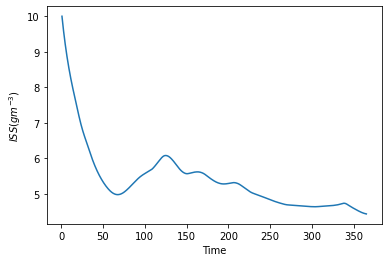

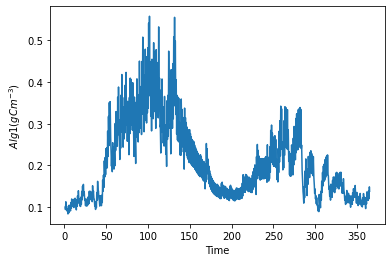

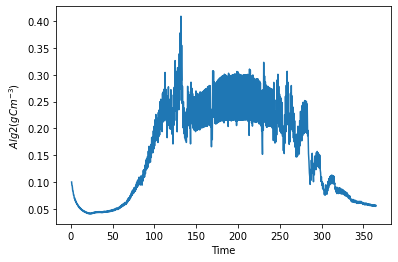

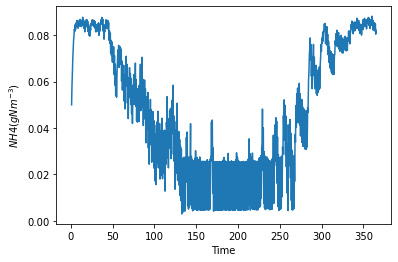

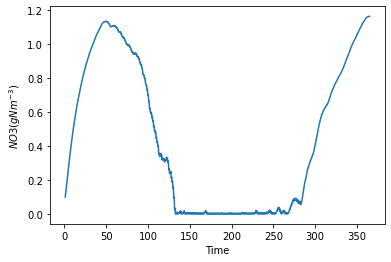

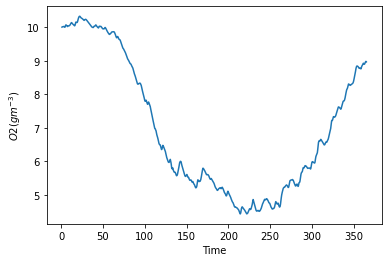

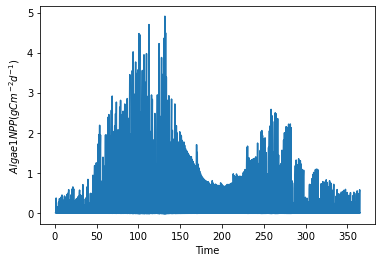

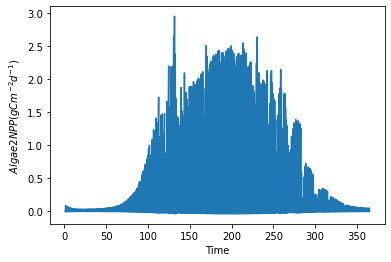

Model Run is All Done, You Can Find Plots in the Outputs/Figures Directory


In [62]:
# Make a Figures Directory if not Exist
OutDir = ICMDir + "/Outputs"
FDir = OutDir + '/Figures'

if not os.path.isdir(OutDir):
    path = os.path.join(ICMDir, 'Outputs')
    os.mkdir(path)

if not os.path.isdir(FDir):
    path = os.path.join(OutDir, 'Figures')
    os.mkdir(path)

# now make some plots of whatever you like and save to the Figures Directory
plt.plot(modtime/86400, ISS)
plt.xlabel('Time')
plt.ylabel('$ISS (g m^{-3})$')
plt.savefig(FDir + '/ISS_ts.png')
plt.show()

plt.plot(modtime/86400, B1)
plt.xlabel('Time')
plt.ylabel('$Alg 1 (gC m^{-3})$')
plt.savefig(FDir + '/Algae2_ts.png')
plt.show()

plt.plot(modtime/86400, B2)
plt.xlabel('Time')
plt.ylabel('$Alg 2 (gC m^{-3})$')
plt.savefig(FDir + '/Algae2_ts.png')
plt.show()


plt.plot(modtime/86400, NH4)
plt.xlabel('Time')
plt.ylabel('$NH4 (gNm^{-3})$')
plt.savefig(FDir + '/NH4_ts.png')
plt.show()

plt.plot(modtime/86400, NO3)
plt.xlabel('Time')
plt.ylabel('$NO3 (gNm^{-3})$')
plt.savefig(FDir + '/NO3_ts.png')
plt.show()

plt.plot(modtime/86400, DO2)
plt.xlabel('Time')
plt.ylabel('$O2 (g m^{-3})$')
plt.savefig(FDir + '/DO2_ts.png')
plt.show()

plt.plot(modtime/86400, NPP1)
plt.xlabel('Time')
plt.ylabel('$Algae 1 NPP (g C m^{-2} d^{-1})$')
plt.savefig(FDir + '/NPP_ts.png')
plt.show()

plt.plot(modtime/86400, NPP2)
plt.xlabel('Time')
plt.ylabel('$Algae 2 NPP (g C m^{-2} d^{-1})$')
plt.savefig(FDir + '/NPP_ts.png')
plt.show()


print('Model Run is All Done, You Can Find Plots in the Outputs/Figures Directory')